In [36]:
# # Libraries
import pandas as pd
import numpy as np
import fasttext
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models.fasttext import FastText
from gensim.models.fasttext import load_facebook_model
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Bidirectional, LSTM, Dense, Embedding, Dropout, GlobalMaxPool1D, BatchNormalization, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
from PIL import Image
from tensorflow.keras.optimizers import Adam
import re
from gensim.models.fasttext import load_facebook_vectors
import string
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import fasttext.util
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from nltk.corpus import wordnet
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization
from keras.regularizers import l2
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import Layer
import numpy as np
from gensim.models import FastText
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

In [3]:
# Load train data
train_df = pd.read_csv('olid-training-v1.0.tsv',sep='\t')

# Select only tweet and subtask_a columns
train_df = train_df[["id", "tweet", "subtask_c"]]

# Load test data
test_df = pd.read_csv('testset-levelc.tsv',sep='\t')

# Select only tweet column
# test_df = test_df[["tweet"]]

# Define column names
column_names = ['id', 'label']

# Load labels
labels_df = pd.read_csv("labels-levelc.csv", header=None, names=column_names)

# Merge labels with test data
test_df = test_df.merge(labels_df, on="id")


In [4]:
train_df

,id,tweet,subtask_c
0,86426,@USER She should ask a few native Americans wh...,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,IND
2,16820,Amazon is investigating Chinese employees who ...,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NaN
...,...,...,...
13235,95338,@USER Sometimes I get strong vibes from people...,IND
13236,67210,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NaN
13237,82921,@USER And why report this garbage. We don't g...,OTH
13238,27429,@USER Pussy,NaN


In [5]:
test_df
test_df

,id,tweet,label
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OTH
1,60133,#NoPasaran: Unity demo to oppose the far-right...,GRP
2,83681,. . . What the fuck did he do this time?,IND
3,65507,@USER Do you get the feeling he is kissing @US...,OTH
4,34263,#StopKavanaugh he is liar like the rest of the...,IND
...,...,...,...
208,30778,#StopEtchecopar? Fuck you all 🖕🖕🖕🖕🖕 Que florez...,IND
209,22569,"#Antifa are mentally unstable cowards, pretend...",GRP
210,48938,@USER @USER And Browning looked like dog shit ...,IND
211,41438,All two of them taste like ass. URL,GRP


2. Data Preprocessing:

In [6]:
train_df['text'] = train_df['tweet']
train_df['label'] = train_df['subtask_c']
train_df.head()
train_df = train_df[['label', 'text']]

test_df['text'] = test_df['tweet']
test_df['label'] = test_df['label']
test_df.head()
test_df = test_df[['label', 'text']]


In [7]:
# Drop rows with NULL labels in train_df['sentiment']
train_df.dropna(subset=['label'], inplace=True)

train_df


C:\Users\Ebenh\AppData\Local\Temp\ipykernel_2312\3722666697.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.dropna(subset=['label'], inplace=True)


,label,text
1,IND,@USER @USER Go home you’re drunk!!! @USER #MAG...
5,OTH,@USER Liberals are all Kookoo !!!
7,GRP,@USER was literally just talking about this lo...
9,IND,@USER Canada doesn’t need another CUCK! We alr...
12,IND,@USER you are a lying corrupt traitor!!! Nobod...
...,...,...
13212,IND,@USER @USER Everything else was ten years ago....
13223,GRP,@USER is advocating for conduct within bounds ...
13227,GRP,@USER @USER @USER @USER Liars like the Antifa ...
13235,IND,@USER Sometimes I get strong vibes from people...


In [8]:
test_df

,label,text
0,OTH,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...
1,GRP,#NoPasaran: Unity demo to oppose the far-right...
2,IND,. . . What the fuck did he do this time?
3,OTH,@USER Do you get the feeling he is kissing @US...
4,IND,#StopKavanaugh he is liar like the rest of the...
...,...,...
208,IND,#StopEtchecopar? Fuck you all 🖕🖕🖕🖕🖕 Que florez...
209,GRP,"#Antifa are mentally unstable cowards, pretend..."
210,IND,@USER @USER And Browning looked like dog shit ...
211,GRP,All two of them taste like ass. URL


In [9]:
# Clean text
def clean_text(text):
  text = "".join(c for c in text if c not in string.punctuation)
  tokens = re.split('\W+', text)
  text = [word for word in tokens if word not in stop_words]
  return text

def remove_url(text):
  url = re.compile(r"https?://\S+|www\.\S+")
  return url.sub(r"", text)

def remove_html(text):
  html = re.compile(r"<.*?>")
  return html.sub(r"", text)

def remove_emoji(string):
  emoji_pattern = re.compile(
      "["
      u"\U0001F600-\U0001F64F"  #emoticon
      u"\U0001F300-\U0001F5FF"  #symbols & pictographs
      u"\U0001F680-\U0001F6FF"  #transport & map symbols
      u"\U0001F1E0-\U0001F1FF"  #flags (ios)
      "]+",
      flags=re.UNICODE,
      )
  return emoji_pattern.sub(r"", string)

def remove_punct(text):
  table = str.maketrans("","", string.punctuation)
  return text.translate(table)

def remove_word(string):
  text = re.compile('rt')
  return text.sub(r"", string)

train_df['text'] = train_df['text'].apply((lambda x: re.sub("(?:\@|https?\://)\S+", "", x)))
train_df['text'] = train_df['text'].apply(lambda x: x.lower())
train_df['text'] = train_df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
train_df['text'] = train_df.text.map(lambda x: remove_url(x))
train_df['text'] = train_df.text.map(lambda x: remove_html(x))
train_df['text'] = train_df.text.map(lambda x: remove_emoji(x))
train_df['text'] = train_df.text.map(lambda x: remove_punct(x))
train_df['text'] = train_df.text.map(lambda x: remove_word(x))
train_df['text'] = train_df['text'].str.replace('url', '')
train_df.head()

C:\Users\Ebenh\AppData\Local\Temp\ipykernel_2312\1325535545.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df['text'].apply((lambda x: re.sub("(?:\@|https?\://)\S+", "", x)))
C:\Users\Ebenh\AppData\Local\Temp\ipykernel_2312\1325535545.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df['text'].apply(lambda x: x.lower())
C:\Users\Ebenh\AppData\Local\Temp\ipykernel_2312\1325535545.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy 

,label,text
1,IND,go home youre drunk maga trump2020
5,OTH,liberals are all kookoo
7,GRP,was literally just talking about this lol all...
9,IND,canada doesnt need another cuck we already ha...
12,IND,you are a lying corrupt traitor nobody wants ...


In [10]:
test_df['text'] = test_df['text'].apply((lambda x: re.sub("(?:\@|https?\://)\S+", "", x)))
test_df['text'] = test_df['text'].apply(lambda x: x.lower())
test_df['text'] = test_df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
test_df['text'] = test_df.text.map(lambda x: remove_url(x))
test_df['text'] = test_df.text.map(lambda x: remove_html(x))
test_df['text'] = test_df.text.map(lambda x: remove_emoji(x))
test_df['text'] = test_df.text.map(lambda x: remove_punct(x))
test_df['text'] = test_df.text.map(lambda x: remove_word(x))
test_df['text'] = test_df['text'].str.replace('url', '')
test_df.head()

C:\Users\Ebenh\AppData\Local\Temp\ipykernel_2312\3808688845.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df['text'].apply((lambda x: re.sub("(?:\@|https?\://)\S+", "", x)))
C:\Users\Ebenh\AppData\Local\Temp\ipykernel_2312\3808688845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df['text'].apply(lambda x: x.lower())
C:\Users\Ebenh\AppData\Local\Temp\ipykernel_2312\3808688845.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

,label,text
0,OTH,whoisq wherestheserver dumpnike declasfisa dem...
1,GRP,nopasaran unity demo to oppose the farright in...
2,IND,what the fuck did he do this time
3,OTH,do you get the feeling he is kissing behind ...
4,IND,stopkavanaugh he is liar like the rest of the ...


In [11]:
# # Lowercasing
# df['text'] = df['text'].str.lower()
# df.head()

In [12]:
# Tokenization
train_df['text'] = train_df['text'].apply(word_tokenize)
train_df.head()

C:\Users\Ebenh\AppData\Local\Temp\ipykernel_2312\895518308.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df['text'].apply(word_tokenize)


,label,text
1,IND,"[go, home, youre, drunk, maga, trump2020]"
5,OTH,"[liberals, are, all, kookoo]"
7,GRP,"[was, literally, just, talking, about, this, l..."
9,IND,"[canada, doesnt, need, another, cuck, we, alre..."
12,IND,"[you, are, a, lying, corrupt, traitor, nobody,..."


In [13]:
# Tokenization
test_df['text'] = test_df['text'].apply(word_tokenize)
test_df.head()

C:\Users\Ebenh\AppData\Local\Temp\ipykernel_2312\1630069719.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df['text'].apply(word_tokenize)


,label,text
0,OTH,"[whoisq, wherestheserver, dumpnike, declasfisa..."
1,GRP,"[nopasaran, unity, demo, to, oppose, the, farr..."
2,IND,"[what, the, fuck, did, he, do, this, time]"
3,OTH,"[do, you, get, the, feeling, he, is, kissing, ..."
4,IND,"[stopkavanaugh, he, is, liar, like, the, rest,..."


In [14]:
# # Stop word removal
# stop_words = set(stopwords.words('english'))
# train_df['text'] = train_df['text'].apply(lambda x: [word for word in x if word not in stop_words])
# train_df.head()

In [15]:
# # Stop word removal
# stop_words = set(stopwords.words('english'))
# test_df['text'] = test_df['text'].apply(lambda x: [word for word in x if word not in stop_words])
# test_df.head()

In [16]:
# # Lemmatization
# lemmatizer = WordNetLemmatizer()
# df['text'] = df['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
# df.head()

In [17]:
# import random

# def synonym_replacement(text, n):
#     new_text = text.copy()
#     random_word_list = list(set([word for word in text if word not in stop_words]))
#     random.shuffle(random_word_list)
#     num_replaced = 0
    
#     for random_word in random_word_list:
#         synonyms = get_synonyms(random_word)
#         if len(synonyms) >= 1:
#             synonym = random.choice(synonyms)
#             new_text = [synonym if word == random_word else word for word in new_text]
#             num_replaced += 1
        
#         if num_replaced >= n:  # Only replace up to n words
#             break

#     sentence = ' '.join(new_text)
#     new_words = sentence.split(' ')

#     return new_words

# def get_synonyms(word):
#     synonyms = set()
#     for syn in wordnet.synsets(word):
#         for lemma in syn.lemmas():
#             synonym = lemma.name().replace("_", " ").replace("-", " ").lower()
#             synonym = "".join([char for char in synonym if char in ' abcdefghijklmnopqrstuvwxyz'])
#             synonyms.add(synonym)
#     if word in synonyms:
#         synonyms.remove(word)
#     return list(synonyms)


In [18]:
# df = df_augmented
# df.head()

In [19]:
# df['text'] = df['text_augmented']
# df = df[['sentiment', 'text']]
# df.head()

In [20]:
# train_data = df
# train_data.head()

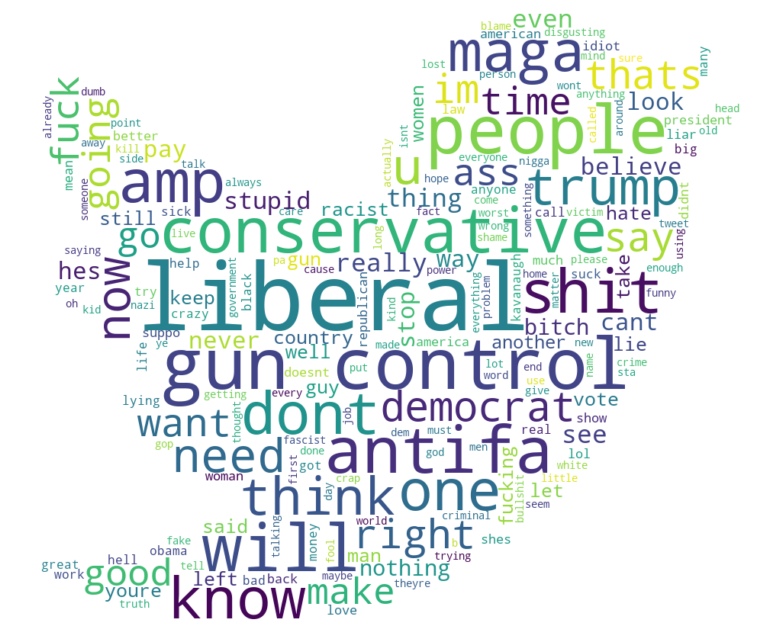

In [21]:
# Visualization Word Cloud
text = ' '.join([' '.join(tweet) for tweet in train_df['text']])
twitter_mask = np.array(Image.open("twitter_mask.png"))
wordcloud = WordCloud(mask=twitter_mask, background_color="white").generate(text)

plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

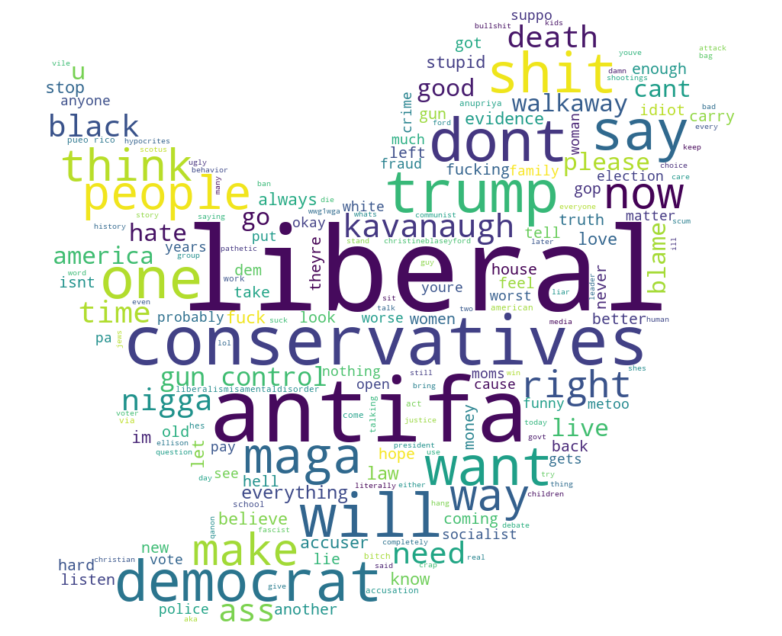

In [22]:
# Visualization Word Cloud
text = ' '.join([' '.join(tweet) for tweet in test_df['text']])
twitter_mask = np.array(Image.open("twitter_mask.png"))
wordcloud = WordCloud(mask=twitter_mask, background_color="white").generate(text)

plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Test_data

In [23]:
# # TEST DATA
# import pandas as pd

# # Membaca data dari file testset-levela.tsv
# tweet = pd.read_csv('testset-levela.tsv', sep='\t')

# # Membaca label dari file labels-levela.csv
# labels = pd.read_csv('labels-levela.csv', header=None, names=['id', 'label'])

# # Menggabungkan data uji dengan label berdasarkan kolom 'id'
# test_data = pd.merge(tweet, labels, on='id')

# # Menampilkan DataFrame hasil
# print(test_data.head())


In [24]:
# labels

In [25]:
# test_data['text'] = test_data['tweet']
# test_data['sentiment'] = test_data['label']
# test_data.head()
# # Drop unnecessary columns
# test_data = test_data[['sentiment', 'text']]
# test_data

In [26]:
# test_data['text'] = test_data['text'].apply((lambda x: re.sub("(?:\@|https?\://)\S+", "", x)))
# test_data['text'] = test_data['text'].apply(lambda x: x.lower())
# test_data['text'] = test_data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
# test_data['text'] = test_data.text.map(lambda x: remove_url(x))
# test_data['text'] = test_data.text.map(lambda x: remove_html(x))
# test_data['text'] = test_data.text.map(lambda x: remove_emoji(x))
# test_data['text'] = test_data.text.map(lambda x: remove_punct(x))
# test_data['text'] = test_data.text.map(lambda x: remove_word(x))
# test_data.head()

In [27]:
# # Lowercasing
# test_data['text'] = test_data['text'].str.lower()
# test_data.head()

In [28]:
# # Tokenization
# test_data['text'] = test_data['text'].apply(word_tokenize)
# test_data.head()

In [29]:
# # Visualization Word Cloud
# text = ' '.join([' '.join(tweet) for tweet in test_data['text']])
# twitter_mask = np.array(Image.open("twitter_mask.png"))
# wordcloud = WordCloud(mask=twitter_mask, background_color="white").generate(text)

# plt.figure(figsize=(10,8))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis('off')
# plt.show()

EMBEDDING

In [30]:
# Load pre-trained FastText model
fasttext_model = FastText.load_fasttext_format('cc.en.300.bin')
# fasttext_model = fasttext.load_model('cc.en.300.bin')

C:\Users\Ebenh\AppData\Local\Temp\ipykernel_2312\2865677329.py:2: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  fasttext_model = FastText.load_fasttext_format('cc.en.300.bin')


In [31]:

tfidf_vectorizer = TfidfVectorizer()
def create_text_embeddings(df, fasttext_model, tfidf_vectorizer):
    # Fit the TF-IDF vectorizer on the training data
    if not tfidf_vectorizer.get_params()['input'] == 'content':
        # Assuming 'content' input is used, change it if needed
        tfidf_vectorizer.set_params(input='content')

    flat_list_of_tokens = [' '.join(text) for text in df['text']]
    tfidf_result = tfidf_vectorizer.fit_transform(flat_list_of_tokens).toarray()

    # Create a dictionary to hold TF-IDF weighted vectors
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_vectors = {}
    for word in tfidf_feature_names:
        if word in fasttext_model.wv.key_to_index:
            word_tfidf_weight = tfidf_vectorizer.idf_[tfidf_vectorizer.vocabulary_[word]]
            word_vector = fasttext_model.wv[word]
            tfidf_vectors[word] = word_vector * word_tfidf_weight

    # Function to blend the FastText and TF-IDF vectors for a document
    def blend_vectors(row):
        vectors = [tfidf_vectors.get(word, np.zeros(fasttext_model.vector_size)) for word in row['text']]
        if vectors:
            return np.mean(vectors, axis=0)
        else:
            return np.zeros(fasttext_model.vector_size)

    # Apply the blending function to each row
    df['text_embeddings'] = df.apply(blend_vectors, axis=1)

    return df

# Usage
train_df = create_text_embeddings(train_df, fasttext_model, tfidf_vectorizer)
test_df = create_text_embeddings(test_df, fasttext_model, tfidf_vectorizer)

# Visualize the embedding
print(train_df[['text_embeddings']].head())
print(test_df[['text_embeddings']].head())


C:\Users\Ebenh\AppData\Local\Temp\ipykernel_2312\2705787062.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_embeddings'] = df.apply(blend_vectors, axis=1)


                                      text_embeddings
1   [0.09802832454442978, -0.005069854358832042, -...
5   [0.095844686, 0.10424848, -0.16953443, 0.35332...
7   [-0.053033486, 0.005556894, 0.15538451, 0.4058...
9   [0.1198075487692323, -0.32708799476838774, 0.0...
12  [-0.07520291852027489, 0.041703833950062594, 0...
                                     text_embeddings
0  [-0.12116547849029302, -0.03637284651398659, 0...
1  [-0.07007613372323769, -0.14273262156971864, 0...
2  [0.105442986, 0.007094536, 0.12322523, 0.22681...
3  [0.09339633, -0.091745645, 0.13951376, 0.11897...
4  [-0.1098349882857292, -0.12757149040699006, -0...


C:\Users\Ebenh\AppData\Local\Temp\ipykernel_2312\2705787062.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_embeddings'] = df.apply(blend_vectors, axis=1)


In [32]:
train_df

,label,text,text_embeddings
1,IND,"[go, home, youre, drunk, maga, trump2020]","[0.09802832454442978, -0.005069854358832042, -..."
5,OTH,"[liberals, are, all, kookoo]","[0.095844686, 0.10424848, -0.16953443, 0.35332..."
7,GRP,"[was, literally, just, talking, about, this, l...","[-0.053033486, 0.005556894, 0.15538451, 0.4058..."
9,IND,"[canada, doesnt, need, another, cuck, we, alre...","[0.1198075487692323, -0.32708799476838774, 0.0..."
12,IND,"[you, are, a, lying, corrupt, traitor, nobody,...","[-0.07520291852027489, 0.041703833950062594, 0..."
...,...,...,...
13212,IND,"[everything, else, was, ten, years, ago, you, ...","[-0.11381470064375677, 0.04659948767773036, 0...."
13223,GRP,"[is, advocating, for, conduct, within, bounds,...","[0.0378842880922805, -0.04071536927443484, 0.0..."
13227,GRP,"[liars, like, the, antifa, twins, you, vigorou...","[-0.061389714, -0.03788937, -0.020085137, 0.26..."
13235,IND,"[sometimes, i, get, strong, vibes, from, peopl...","[0.0500639650702436, -0.16389480010484872, -0...."


In [33]:
# # Binary encoding of sentiment
# train_df['sentiment'] = train_df['sentiment'].apply(lambda x: 1 if x == 'UNT' else 0)
# test_df['sentiment'] = test_df['sentiment'].apply(lambda x: 1 if x == 'UNT' else 0)

In [34]:
test_df

,label,text,text_embeddings
0,OTH,"[whoisq, wherestheserver, dumpnike, declasfisa...","[-0.12116547849029302, -0.03637284651398659, 0..."
1,GRP,"[nopasaran, unity, demo, to, oppose, the, farr...","[-0.07007613372323769, -0.14273262156971864, 0..."
2,IND,"[what, the, fuck, did, he, do, this, time]","[0.105442986, 0.007094536, 0.12322523, 0.22681..."
3,OTH,"[do, you, get, the, feeling, he, is, kissing, ...","[0.09339633, -0.091745645, 0.13951376, 0.11897..."
4,IND,"[stopkavanaugh, he, is, liar, like, the, rest,...","[-0.1098349882857292, -0.12757149040699006, -0..."
...,...,...,...
208,IND,"[stopetchecopar, fuck, you, all, que, florezca...","[0.35392712574038243, -0.521877781384521, 0.11..."
209,GRP,"[antifa, are, mentally, unstable, cowards, pre...","[-0.09185383, -0.23800169, -0.08338666, 0.3421..."
210,IND,"[and, browning, looked, like, dog, shit, again...","[0.07575276, 0.008594581, 0.09675083, 0.416446..."
211,GRP,"[all, two, of, them, taste, like, ass]","[0.056213405, -0.093169406, 0.24474947, 0.1941..."


4. LSTM

In [46]:
# # Convert embeddings and labels to numpy format for train_df
# X_train = np.array(train_df['text_embeddings'].tolist())
# y_train = train_df['label'].values

# # Apply SMOTE to oversample the minority classes
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# # Convert labels to categorical format
# label_encoder = LabelEncoder()
# y_train_encoded = to_categorical(label_encoder.fit_transform(y_train_resampled), num_classes=3)

# # Reshape train data for LSTM
# X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], 1, X_train_resampled.shape[1])

# # Split train data into training and validation
# X_train, X_val, y_train, y_val = train_test_split(X_train_resampled, y_train_encoded, test_size=0.2, random_state=42)

# # Convert embeddings and labels to numpy format for test_df
# X_test = np.array(test_df['text_embeddings'].tolist())

# filtered_test_df = test_df[test_df['label'].isin(y_train)]

# # Extract labels for test data
# y_test = filtered_test_df['label'].values

# # Reshape test data for LSTM
# X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# # Reshape y_train for compatibility with LSTM output
# y_train = y_train.reshape(y_train.shape[0], 1)


In [47]:
# label_encoder = LabelEncoder()
# y_train_encoded = to_categorical(label_encoder.fit_transform(y_train), num_classes=3)
# y_val_encoded = to_categorical(label_encoder.transform(y_val), num_classes=3)

In [49]:
# Convert embeddings and labels to numpy format for train_df
X_train = np.array(train_df['text_embeddings'].tolist())
y_train = train_df['label'].values

# Apply SMOTE to oversample the minority classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Convert labels to categorical format
label_encoder = LabelEncoder()
y_train_encoded = to_categorical(label_encoder.fit_transform(y_train_resampled), num_classes=3)

# Reshape train data for LSTM
X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], 1, X_train_resampled.shape[1])

# Split train data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_resampled, y_train_encoded, test_size=0.2, random_state=42)

# Convert embeddings and labels to numpy format for test_df
X_test = np.array(test_df['text_embeddings'].tolist())

# Extract labels for test data
y_test = test_df['label'].values

# Reshape test data for LSTM
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [50]:


# tf.compat.v1.disable_eager_execution()
model = Sequential()
# model.add(BatchNormalization(input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Bidirectional(LSTM(196, return_sequences=True, recurrent_dropout=0.2), input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Bidirectional(LSTM(196, return_sequences=True, recurrent_dropout=0.2), input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Bidirectional(LSTM(196, return_sequences=True, recurrent_dropout=0.2)))
# model.add(Bidirectional(LSTM(196, return_sequences=True, recurrent_dropout=0.2)))
model.add(Bidirectional(LSTM(196, return_sequences=True)))
# model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(max_length, activation = "relu"))
# model.add(Dropout(0.5))
# model.add(Dense(max_length, activation = "relu"))
model.add(Dropout(0.5))
# model.add(Dense(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(42, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(21, activation="relu"))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 1, 392)            779296    
 onal)                                                           
                                                                 
 global_max_pooling1d_1 (Gl  (None, 392)               0         
 obalMaxPooling1D)                                               
                                                                 
 batch_normalization_1 (Bat  (None, 392)               1568      
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 392)               0         
                                                                 
 dense_3 (Dense)             (None, 42)                16506     
                                                      

In [55]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])
# history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])
# history = model.fit(X_train, y_train, epochs=7, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100
181/181 [==============================] - 9s 17ms/step - loss: 1.1164 - accuracy: 0.4616 - val_loss: 1.0882 - val_accuracy: 0.4630
Epoch 2/100
181/181 [==============================] - 2s 13ms/step - loss: 0.9596 - accuracy: 0.5322 - val_loss: 1.0300 - val_accuracy: 0.5612
Epoch 3/100
181/181 [==============================] - 4s 22ms/step - loss: 0.9305 - accuracy: 0.5694 - val_loss: 0.9183 - val_accuracy: 0.6194
Epoch 4/100
181/181 [==============================] - 4s 22ms/step - loss: 0.8836 - accuracy: 0.5881 - val_loss: 0.8539 - val_accuracy: 0.6519
Epoch 5/100
181/181 [==============================] - 3s 18ms/step - loss: 0.8477 - accuracy: 0.6150 - val_loss: 0.8382 - val_accuracy: 0.6374
Epoch 6/100
181/181 [==============================] - 2s 14ms/step - loss: 0.8149 - accuracy: 0.6416 - val_loss: 0.7994 - val_accuracy: 0.6740
Epoch 7/100
181/181 [==============================] - 2s 13ms/step - loss: 0.7887 - accuracy: 0.6484 - val_loss: 0.7812 - val_accuracy:

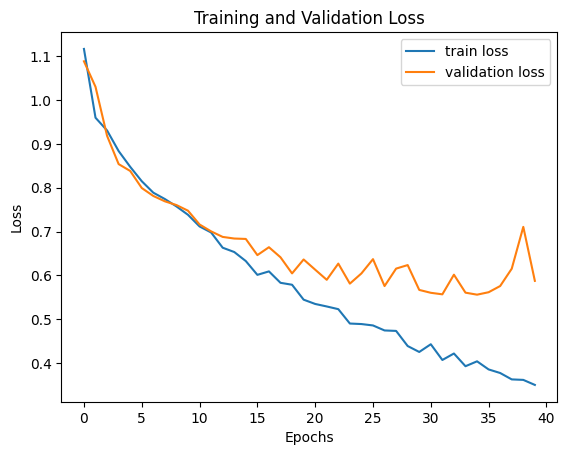

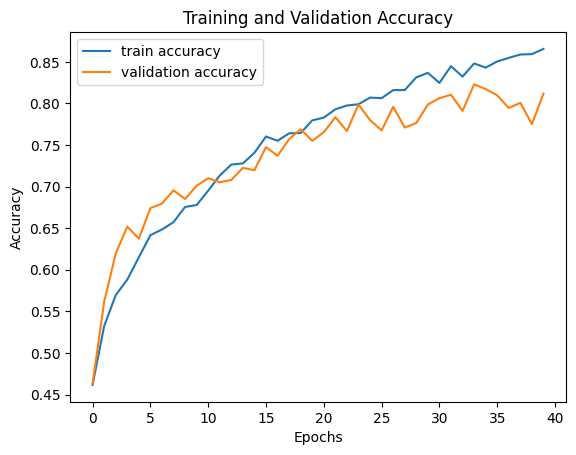

In [57]:
# Graph Result
# Plotting the training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [59]:
# Evaluate the model on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = label_encoder.transform(y_test)

# Define target names for classification report
target_names = ['GRP', 'IND', 'OTH']

# Print classification report with string labels
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=target_names))

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print("Accuracy:", accuracy)

# Calculate F1 macro
f1_macro = f1_score(y_true, y_pred_classes, average='macro')
print("F1 Macro:", f1_macro)

7/7 [==============================] - 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

         GRP       0.58      0.63      0.60        78
         IND       0.69      0.73      0.71       100
         OTH       0.27      0.17      0.21        35

    accuracy                           0.60       213
   macro avg       0.51      0.51      0.51       213
weighted avg       0.58      0.60      0.59       213

Accuracy: 0.6009389671361502
F1 Macro: 0.506830391244058
